Importamos las librerias necesarias para el proyecto

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pathlib import Path 

In [8]:
print("ANÁLISIS DE PRECIOS DE AGUACATES CON RANDOM FOREST")

# 1. CARGAR Y EXPLORAR DATOS
print("\n Paso 1: Cargando datos y explorandolos.")

# Directorio actual (donde está tu notebook)
current_dir = Path.cwd()
print(f" Directorio actual del notebook: {current_dir}")

# SOLUCIÓN: Subir 2 niveles para llegar a avocado-regression-project
project_root = current_dir.parent.parent
print(f" Directorio del proyecto: {project_root}")

# Construir la ruta CORRECTA
csv_path = project_root / 'data' / 'raw' / 'avocado.csv'
print(f" Buscando en: {csv_path}")

# Verificar si existe
if csv_path.exists():
    df = pd.read_csv(csv_path)
    print(f" Archivo cargado desde: {csv_path}")
else:
    print("No se encontró en la ruta especificada :c")
    
    # Debug: mostrar estructura desde project_root
    print("\n Estructura desde project_root:")
    data_dir = project_root / 'data'
    if data_dir.exists():
        print(" Carpeta encontrada con exito.")
        for item in data_dir.iterdir():
            if item.is_dir():
                print(f"  {item.name}/")
                for subitem in item.iterdir():
                    print(f"    - {subitem.name}")
            else:
                print(f" {item.name}")
    else:
        print("Carpeta 'data' no encontrada")
    
    raise FileNotFoundError(f"No se encontró 'avocado.csv'")

print(f" Datos cargados con exito :D")


print(f"Dimensiones: {df.shape}")
print(f"\nPrimeras filas:\n{df.head()}")
print(f"\nTipos de datos:\n{df.dtypes}")
print(f"\nValores faltantes:\n{df.isnull().sum()}")

# Manejar variables categóricas
df = pd.get_dummies(df, columns=['type', 'region'], drop_first=True)

# Eliminar columnas no numéricas o que no queremos usar
# (Ajusta según tu dataset)
columnas_a_eliminar = ['Date', 'Unnamed: 0']  # Ejemplo
df = df.drop(columns=[col for col in columnas_a_eliminar if col in df.columns])

# Definir variable objetivo (y) y características (X)
# SUPOSICIÓN: 'AveragePrice' es lo que queremos predecir
X = df.drop('AveragePrice', axis=1)
y = df['AveragePrice']

print(f"Características: {X.shape[1]}")
print(f"Registros: {X.shape[0]}")

# 3. DIVIDIR DATOS
print("\n Paso 3: Dividimos datos...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
print(f"Entrenamiento: {X_train.shape[0]} | Prueba: {X_test.shape[0]}")

ANÁLISIS DE PRECIOS DE AGUACATES CON RANDOM FOREST

 Paso 1: Cargando datos y explorandolos.
 Directorio actual del notebook: /home/joseph/Documentos/Ingenieria de Sistemas/Ciencia de datos/Proyecto2-CienciaDatos/avocado-regression-project/models/random_forest
 Directorio del proyecto: /home/joseph/Documentos/Ingenieria de Sistemas/Ciencia de datos/Proyecto2-CienciaDatos/avocado-regression-project
 Buscando en: /home/joseph/Documentos/Ingenieria de Sistemas/Ciencia de datos/Proyecto2-CienciaDatos/avocado-regression-project/data/raw/avocado.csv
 Archivo cargado desde: /home/joseph/Documentos/Ingenieria de Sistemas/Ciencia de datos/Proyecto2-CienciaDatos/avocado-regression-project/data/raw/avocado.csv
 Datos cargados con exito :D
Dimensiones: (18249, 14)

Primeras filas:
   Unnamed: 0        Date  AveragePrice  Total Volume     4046       4225  \
0           0  2015-12-27          1.33      64236.62  1036.74   54454.85   
1           1  2015-12-20          1.35      54876.98   674.28   4

En el 4to paso nos encargamos de buscar los hiperparametros optimos para el modelo de Random Forest, el cual usamos n_estimators (Entre mas, mejor precision pero mas tiempo de entrenamiento), min_samples_split (Minimo numero de muestras necesarias para dividir un nodo) y min_samples_leaf (Minimo numero de muestras necesarias en una hoja). Utilizamos GridSearchCV para buscar la mejor combinacion de hiperparametros.

In [9]:
# 4. OPTIMIZACIÓN DE HIPERPARÁMETROS CON GRIDSEARCHCV

print("\n Paso 4: Buscando hiperparametros optimos.")
print("   Esto puede demorar un poco, así que se paciente ;)")


param_grid = {
    'n_estimators': [150, 250],           # 2 valores (Numero de arboles en el bosque)
    'max_depth': [12, 18, None],          # 3 valores (Maxima profundidad del arbol. None = sin límite)
    'min_samples_split': [2, 5],          # 2 valores (2 y 5 son los más comunes)
    'min_samples_leaf': [1, 2]            # 2 valores (1 y 2 casi siempre son óptimos)
}
# Total: 2 × 3 × 2 × 2 = 24 combinaciones × 5-fold CV = 120 entrenamientos

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,               #Cross validation. Divide los datos en 5 partes iguales y hace 5 entrenamientos
    scoring='r2',       #Porcentaje de variabilidad explicada (0-1, más alto = mejor)
    n_jobs=-1,          #Usa todos los núcleos del CPU para acelerar (1 core, 2 3 4 5 -> numero de cores a usar)
    verbose=1           #Muestra el progreso en la consola (0 Silencioso, 1 Normal, 2 Detallado)
)

grid_search.fit(X_train, y_train)

print(f"\n Busqueda completada")
print(f"Mejores parametros: {grid_search.best_params_}")
print(f"Mejor score en CV: {grid_search.best_score_:.4f}")

#Calcular MSE para el mejor modelo
best_model = grid_search.best_estimator_
cv_mse_scores = cross_val_score(best_model, X_train, y_train, 
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cv_mse_scores = -cv_mse_scores  # Convertir a positivo
print(f"Mejor MSE en CV: {cv_mse_scores.mean():.4f} (+/- {cv_mse_scores.std():.4f})")



 Paso 4: Buscando hiperparametros optimos.
   Esto puede demorar un poco, así que se paciente ;)
Fitting 5 folds for each of 24 candidates, totalling 120 fits



 Busqueda completada
Mejores parametros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}
Mejor score en CV: 0.8461
Mejor MSE en CV: 0.0250 (+/- 0.0013)


In [10]:
# 5. ENTRENAR MODELO FINAL CON MEJORES PARÁMETROS
print("\n Paso 5: Entrenando al modelo.")

rf_model = grid_search.best_estimator_      #Toma el mejor modelo encontrado en la busqueda de hiperparametros

# Validación cruzada con modelo final
cv_scores = cross_val_score(rf_model, X_train, y_train,     
                            cv=5, scoring='r2', n_jobs=-1)  # Evalúa el modelo final usando cross validation con 5 folds.
print(f"Validación cruzada (5-fold):")
print(f"  Scores: {[f'{s:.4f}' for s in cv_scores]}")
print(f"  Media: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# 6. PREDICCIONES
print("\n Paso 6: Realizando predicciones.")
y_pred_train = rf_model.predict(X_train)    #Usa el modelo para predecir los mismos datos con los que se entrenó.
y_pred_test = rf_model.predict(X_test)      #Predice datos NUNCA VISTOS durante el entrenamiento.

print(y_pred_train)
print(y_pred_test)


 Paso 5: Entrenando al modelo.
Validación cruzada (5-fold):
  Scores: ['0.8562', '0.8424', '0.8540', '0.8398', '0.8382']
  Media: 0.8461 (+/- 0.0075)

 Paso 6: Realizando predicciones.
[1.8698  0.83572 2.0078  ... 1.2894  1.15156 1.48548]
[1.02676 0.98316 1.39012 ... 0.59408 1.65544 2.015  ]


R² -> 0.8461: el modelo explica el 84.61% de la variabilidad en los precios
Estabilidad -> Desviación ±0.0075 significa que el modelo es consistente
Consistencia -> Los scores estan entre 0.8382 y 0.8562

In [11]:
# 7. EVALUACIÓN COMPLETA
print("\n Paso 7: Evaluacion del modelo")

def calcular_metricas(y_true, y_pred, nombre_conjunto):
    """Calculamos e imprimimos todas las métricas"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    #MSE como porcentaje del rango de precios
    rango_precios = y_true.max() - y_true.min()
    mse_porcentaje = (mse / (rango_precios ** 2)) * 100
    
    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n CONJUNTO {nombre_conjunto}:")
    print(f"   MSE (Error Cuadrático Medio):        {mse:.4f}")
    print(f"   MSE (% del rango de precios):        {mse_porcentaje:.2f}%")
    print(f"   RMSE (Raíz del Error Cuadrático):   ${rmse:.2f}")
    print(f"   MAE (Error Absoluto Medio):         ${mae:.2f}")
    print(f"   MAPE (Error Porcentual Medio):      {mape:.2f}%")
    print(f"   R² (Coeficiente de Determinación):  {r2:.4f}")
    
    return {'mse': mse, 'mse_porcentaje': mse_porcentaje, 'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape}

metricas_train = calcular_metricas(y_train, y_pred_train, "ENTRENAMIENTO")
metricas_test = calcular_metricas(y_test, y_pred_test, "PRUEBA")

# R² Ajustado
n = X_test.shape[0]
p = X_test.shape[1]
r2_adj = 1 - (1 - metricas_test['r2']) * (n - 1) / (n - p - 1)
print(f"   R² Ajustado:                         {r2_adj:.4f}")

# Diagnóstico de overfitting
print("\n" + "=" * 70)
diff_r2 = metricas_train['r2'] - metricas_test['r2']
if diff_r2 > 0.15:
    print(f"¡Cuidado! Overfitting detectado (Diferencia R²: {diff_r2:.4f})")
    print("   Considera: aumentar max_depth max, o reducir n_estimators")
elif diff_r2 > 0.05:
    print(f" Ligero overfitting (Diferencia R²: {diff_r2:.4f})")
else:
    print(f"Excelente generalizacion, Durisimo bro. (Diferencia R²: {diff_r2:.4f})")


 Paso 7: Evaluacion del modelo

 CONJUNTO ENTRENAMIENTO:
   MSE (Error Cuadrático Medio):        0.0031
   MSE (% del rango de precios):        0.04%
   RMSE (Raíz del Error Cuadrático):   $0.06
   MAE (Error Absoluto Medio):         $0.04
   MAPE (Error Porcentual Medio):      2.84%
   R² (Coeficiente de Determinación):  0.9808

 CONJUNTO PRUEBA:
   MSE (Error Cuadrático Medio):        0.0231
   MSE (% del rango de precios):        0.30%
   RMSE (Raíz del Error Cuadrático):   $0.15
   MAE (Error Absoluto Medio):         $0.11
   MAPE (Error Porcentual Medio):      7.82%
   R² (Coeficiente de Determinación):  0.8565
   R² Ajustado:                         0.8539

 Ligero overfitting (Diferencia R²: 0.1243)


 Paso 8: Analisis de importancia de variables.

 Interpretacion de variables mas importantes
   1. type_organic: 0.383 (38.3%)
   2. 4046: 0.097 (9.7%)
   3. Large Bags: 0.093 (9.3%)
   4. 4225: 0.073 (7.3%)
   5. year: 0.050 (5.0%)

   Variables con importancia < 1%: 51


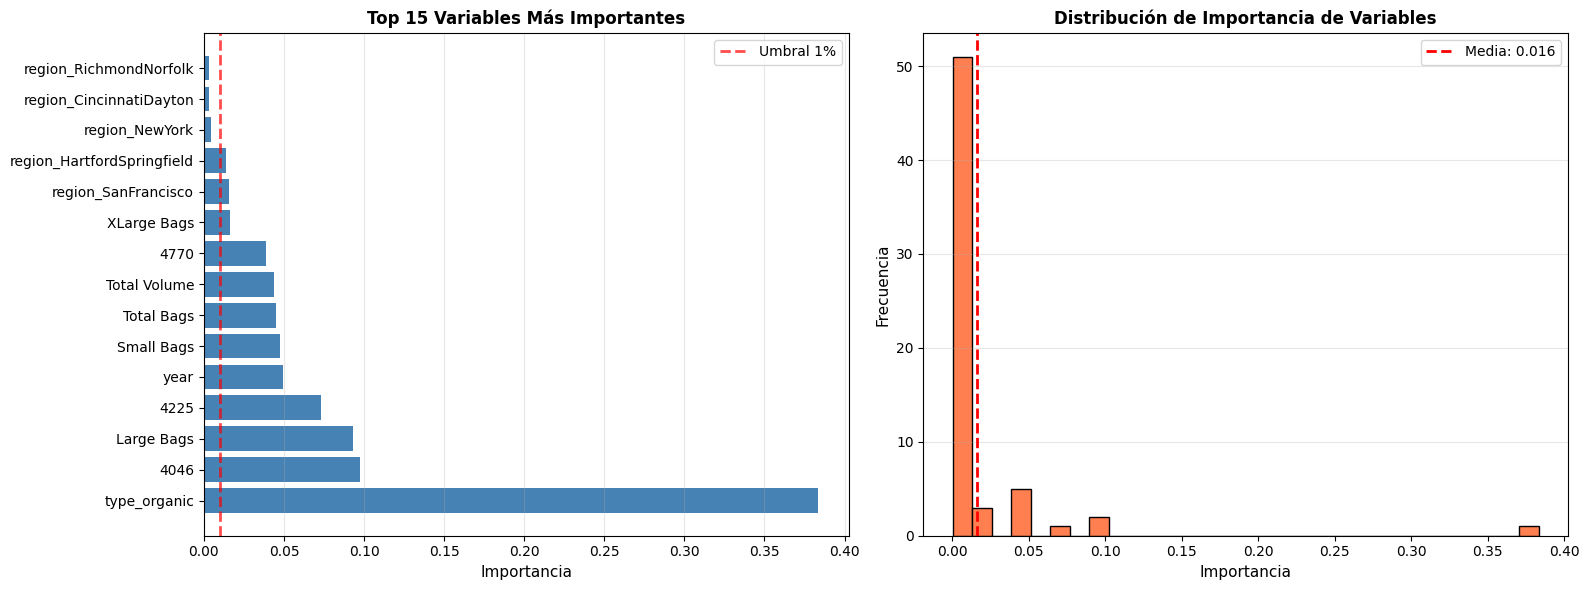

In [12]:
# 8. IMPORTANCIA DE VARIABLES
print(" Paso 8: Analisis de importancia de variables.")

feature_importance = pd.DataFrame({         #Random Forest mide cuánto reduce la impureza cada variable
                                            #Valores entre 0 y 1 (suman 1.0 en total)
                                            # Ejemplo: Si "Total Volume" tiene importancia 0.15 → explica el 15% de las decisiones
    'Variable': X.columns,
    'Importancia': rf_model.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\n Interpretacion de variables mas importantes")
top_features = feature_importance.head(5)
for idx, (_, row) in enumerate(top_features.iterrows(), 1):
    print(f"   {idx}. {row['Variable']}: {row['Importancia']:.3f} ({row['Importancia']*100:.1f}%)") #Las 5 variables mas importantes

print("\n   Variables con importancia < 1%:",               #Variables que aportan poco al modelo o inutiles
      len(feature_importance[feature_importance['Importancia'] < 0.01]))

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 features
axes[0].barh(range(len(feature_importance.head(15))), 
             feature_importance.head(15)['Importancia'].values,
             color='steelblue')
axes[0].set_yticks(range(len(feature_importance.head(15))))
axes[0].set_yticklabels(feature_importance.head(15)['Variable'].values)
axes[0].set_xlabel('Importancia', fontsize=11)
axes[0].set_title('Top 15 Variables Más Importantes', fontsize=12, fontweight='bold')
axes[0].axvline(x=0.01, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Umbral 1%')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Distribución de importancias
axes[1].hist(feature_importance['Importancia'], bins=30, color='coral', edgecolor='black')
axes[1].set_xlabel('Importancia', fontsize=11)
axes[1].set_ylabel('Frecuencia', fontsize=11)
axes[1].set_title('Distribución de Importancia de Variables', fontsize=12, fontweight='bold')
axes[1].axvline(x=feature_importance['Importancia'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"Media: {feature_importance['Importancia'].mean():.3f}")
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Interpretación:

La mayoría de las variables tienen importancia muy baja (< 0.02) → el modelo apenas las usa.

Solo unas pocas (como type_organic, 4046, Large Bags) tienen valores muy altos, lo que indica que son las verdaderamente determinantes para predecir el precio.

Este patrón es típico: pocos factores dominan la predicción, y el resto aportan detalles marginales.

Crea un "reporte detallado" de cada predicción vs la realidad, para entender dónde y cómo falla tu modelo.

| Métrica               | Valor                                            
| --------------------- | ------------------------------------------------- 
| **MAE = $0.11**       | Error promedio de 11 centavos por aguacate.       
| **Mediana = $0.07**   | La mitad de los errores son menores a 7 centavos. 
| **RMSE = $0.15**      | Penaliza más los errores grandes (outliers).      
| **MAPE = 7.82%**      | Error porcentual medio → excelente.               
| **Error máx = $0.85** | Hay algunos casos atípicos con error grande.      


Paso 9: Analisis de predicciones vs realidad

Primeras 10 predicciones:
   Real  Predicho  Diferencia     Error%  Error_Cuadrado
0  0.82   1.02676     0.20676  25.214634        0.042750
1  0.97   0.98316     0.01316   1.356701        0.000173
2  1.44   1.39012     0.04988   3.463889        0.002488
3  0.97   0.92380     0.04620   4.762887        0.002134
4  1.45   1.46292     0.01292   0.891034        0.000167
5  1.29   1.39356     0.10356   8.027907        0.010725
6  2.03   1.73016     0.29984  14.770443        0.089904
7  0.94   0.97080     0.03080   3.276596        0.000949
8  2.45   2.20920     0.24080   9.828571        0.057985
9  1.83   1.66148     0.16852   9.208743        0.028399

 ANÁLISIS DE ERRORES:
   Error promedio (MAE):           $0.11
   Error máximo:                   $0.85
   Error mínimo:                   $0.00
   Percentil 25:                   $0.03
   Mediana (P50):                  $0.07
   Percentil 75:                   $0.14
   Error porcentual promedio:   

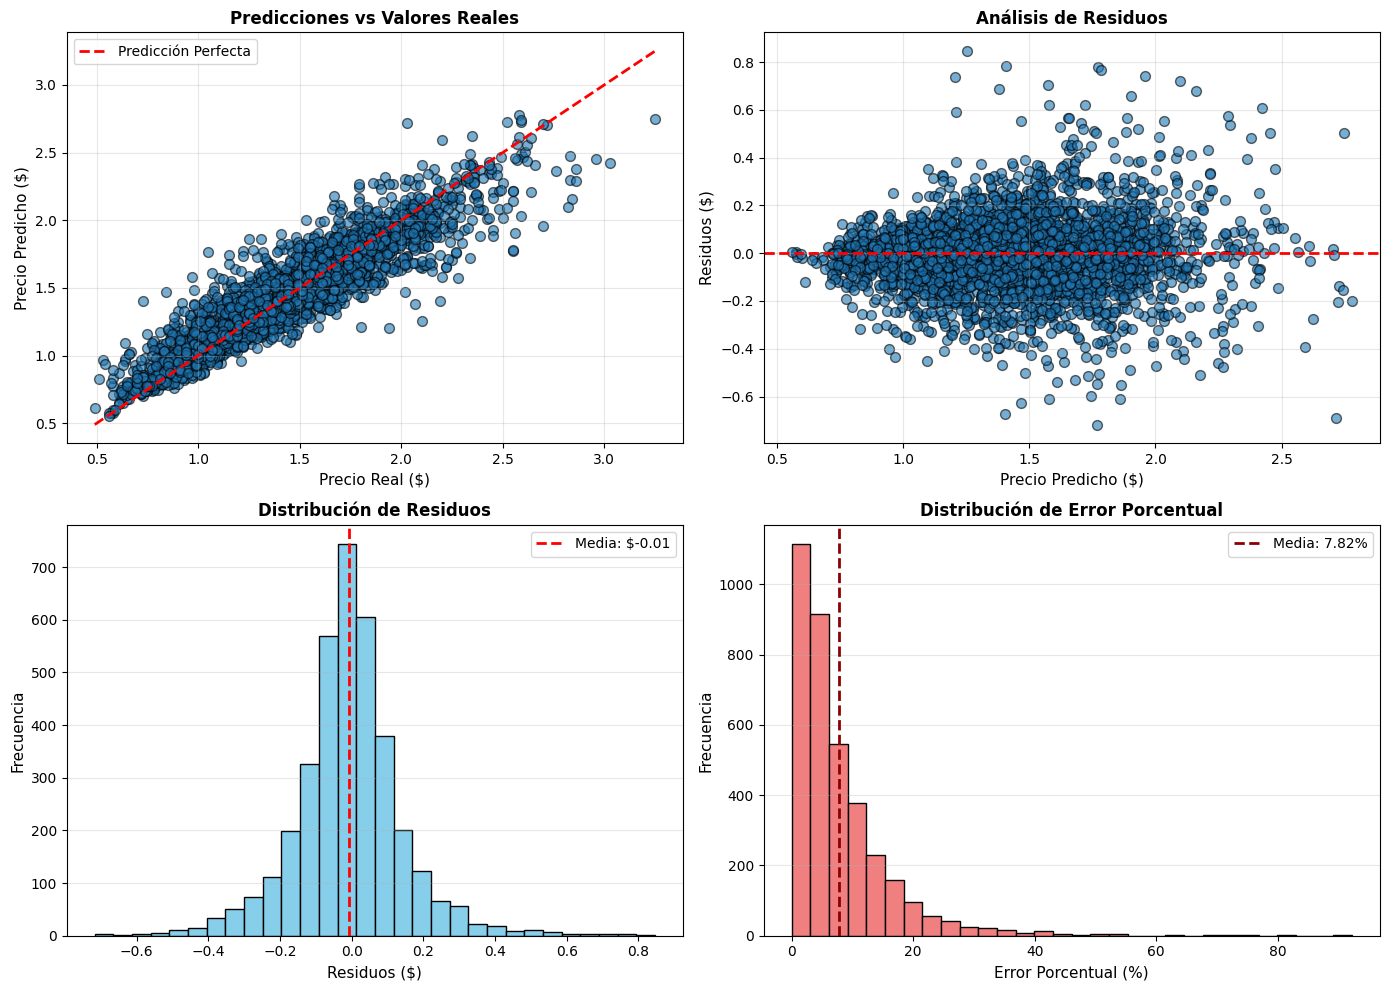

In [13]:
# 9. ANÁLISIS DE PREDICCIONES
print("Paso 9: Analisis de predicciones vs realidad")

comparison_df = pd.DataFrame({
    'Real': y_test.values,
    'Predicho': y_pred_test,
    'Diferencia': np.abs(y_test.values - y_pred_test),
    'Error%': np.abs((y_test.values - y_pred_test) / y_test.values) * 100,
    'Error_Cuadrado': (y_test.values - y_pred_test) ** 2 

})

print("\nPrimeras 10 predicciones:")
print(comparison_df.head(10).to_string())

print(f"\n ANÁLISIS DE ERRORES:")
print(f"   Error promedio (MAE):           ${comparison_df['Diferencia'].mean():.2f}")
print(f"   Error máximo:                   ${comparison_df['Diferencia'].max():.2f}")
print(f"   Error mínimo:                   ${comparison_df['Diferencia'].min():.2f}")
print(f"   Percentil 25:                   ${comparison_df['Diferencia'].quantile(0.25):.2f}")
print(f"   Mediana (P50):                  ${comparison_df['Diferencia'].quantile(0.50):.2f}")
print(f"   Percentil 75:                   ${comparison_df['Diferencia'].quantile(0.75):.2f}")
print(f"   Error porcentual promedio:      {comparison_df['Error%'].mean():.2f}%")

print(f"\n ANÁLISIS MSE:")
print(f"   MSE total:                      {comparison_df['Error_Cuadrado'].mean():.4f}")
print(f"   RMSE:                           ${np.sqrt(comparison_df['Error_Cuadrado'].mean()):.2f}")
print(f"   Percentil 50 errores cuadrados: {comparison_df['Error_Cuadrado'].quantile(0.50):.4f}")
print(f"   Percentil 75 errores cuadrados: {comparison_df['Error_Cuadrado'].quantile(0.75):.4f}")

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Scatter: Predicciones vs Real
axes[0, 0].scatter(y_test, y_pred_test, alpha=0.6, edgecolors='k', s=50)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Predicción Perfecta')
axes[0, 0].set_xlabel('Precio Real ($)', fontsize=11)
axes[0, 0].set_ylabel('Precio Predicho ($)', fontsize=11)
axes[0, 0].set_title('Predicciones vs Valores Reales', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Residuos
residuos = y_test.values - y_pred_test
axes[0, 1].scatter(y_pred_test, residuos, alpha=0.6, edgecolors='k', s=50)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Precio Predicho ($)', fontsize=11)
axes[0, 1].set_ylabel('Residuos ($)', fontsize=11)
axes[0, 1].set_title('Análisis de Residuos', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Distribución de residuos
axes[1, 0].hist(residuos, bins=30, color='skyblue', edgecolor='black')
axes[1, 0].axvline(x=residuos.mean(), color='red', linestyle='--', lw=2, 
                   label=f'Media: ${residuos.mean():.2f}')
axes[1, 0].set_xlabel('Residuos ($)', fontsize=11)
axes[1, 0].set_ylabel('Frecuencia', fontsize=11)
axes[1, 0].set_title('Distribución de Residuos', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Error porcentual
axes[1, 1].hist(comparison_df['Error%'], bins=30, color='lightcoral', edgecolor='black')
axes[1, 1].axvline(x=comparison_df['Error%'].mean(), color='darkred', linestyle='--', lw=2,
                   label=f'Media: {comparison_df["Error%"].mean():.2f}%')
axes[1, 1].set_xlabel('Error Porcentual (%)', fontsize=11)
axes[1, 1].set_ylabel('Frecuencia', fontsize=11)
axes[1, 1].set_title('Distribución de Error Porcentual', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

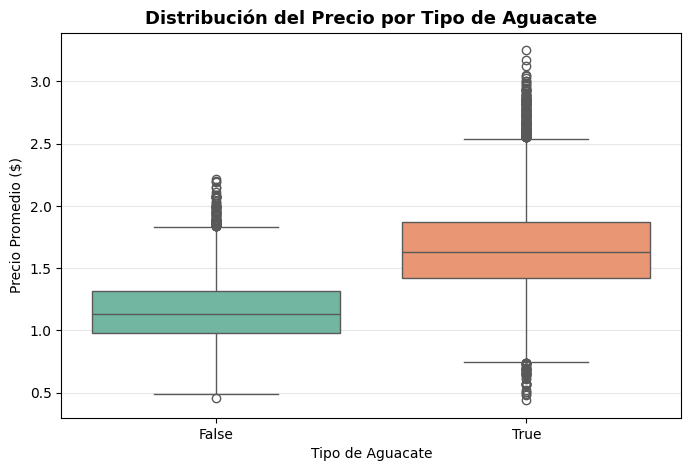

In [16]:
plt.figure(figsize=(8,5))
sns.boxplot(x='type_organic', y='AveragePrice', data=df, palette='Set2')

plt.title('Distribución del Precio por Tipo de Aguacate', fontsize=13, fontweight='bold')
plt.xlabel('Tipo de Aguacate')
plt.ylabel('Precio Promedio ($)')
plt.grid(axis='y', alpha=0.3)
plt.show()


True → Aguacates orgánicos

False → Aguacates convencionales

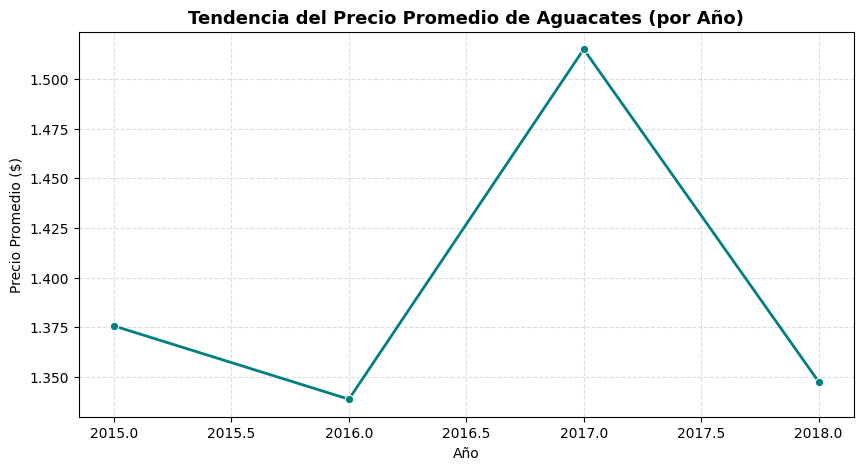

In [17]:
plt.figure(figsize=(10,5))
df_grouped = df.groupby('year')['AveragePrice'].mean().reset_index()

sns.lineplot(x='year', y='AveragePrice', data=df_grouped, marker='o', linewidth=2, color='teal')

plt.title('Tendencia del Precio Promedio de Aguacates (por Año)', fontsize=13, fontweight='bold')
plt.xlabel('Año')
plt.ylabel('Precio Promedio ($)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


In [ ]:
# 10. CONCLUSIONES
print("\n" + "=" * 70)
print("Conclusiones del analisis")
print("=" * 70)

if metricas_test['r2'] > 0.85:
    print("\n Excelente: El modelo explica >85% de la variabilidad")
elif metricas_test['r2'] > 0.7:
    print("\n Bueno: El modelo explica >70% de la variabilidad")
elif metricas_test['r2'] > 0.5:
    print("\n Aceptable: El modelo explica >50% de la variabilidad")
else:
    print("\n Mejorable: Considera agregar más características o probar otros modelos")

print(f"\nError típico: ±${metricas_test['mae']:.2f}")
print(f"Error porcentual típico: ±{comparison_df['Error%'].mean():.2f}%")
print(f"MSE (Error Cuadrático): {metricas_test['mse']:.4f}")
print(f"MSE (% del rango): {metricas_test['mse_porcentaje']:.2f}%")  


print("¡ANÁLISIS COMPLETADO!")



Conclusiones del analisis

 Excelente: El modelo explica >85% de la variabilidad

Error típico: ±$0.11
Error porcentual típico: ±7.82%
MSE (Error Cuadrático): 0.0231
MSE (% del rango): 0.30%
¡ANÁLISIS COMPLETADO!
